In [1]:
import torch
import pyro
from pyro.distributions import *
from collections import Counter
import pyro.infer
import pyro.optim
pyro.enable_validation(True)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import numpy as np
import pandas as pd

# A Cognitive Model or Harmonic Types

## Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\theta \sim \text{Beta}(1,1)$
- choose $\lambda \sim \text{Gamma}(3,1)$
- for each chord type $i$
  - choose $\vec\phi_{ct}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(i)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta)$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta \vec\phi_{ct}^{(h)} + (1-\theta) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

In [2]:
# fix the range of pitches we consider
fifth_range = 2*7 # 2 diatonics
npcs = 2*fifth_range+1 # around C: Cbb to C## on LoF

In [3]:
#@pyro.infer.config_enumerate
def chord_model(npcs, nharmonies, data, subsamples=500, pobserve=0.5):
    #nchords = chords.size[0]
    
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(0.5 * torch.ones(nharmonies)))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(1, 1))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(0.5 * torch.ones(npcs)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample('rate_notes', Gamma(3,1))
    
    # sampling the data:
    nchords = len(data['h'])
    with pyro.plate('data', nchords, subsample_size=min(nchords,subsamples)) as ind:
        # pick a harmony
        h = pyro.sample('h', Categorical(p_harmony), obs=data['h'][ind])
        # pick a number of notes
        nnotes = 1 + pyro.sample('n', Poisson(rate_notes), obs=data['n'][ind]).int()
        # sample chordtones
        chordtones = pyro.sample('chord', Multinomial(1, p_tones[h], validate_args=False), obs=data['chord'][ind])
        chords = {'h': h, 'n': nnotes,
                 'counts': chordtones.reshape(-1,npcs)}
    return chords

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [4]:
def chord_guide(npcs, nharmonies, data, subsamples=500, pobserve=0.5):
    # posterior of p_harmony
    params_p_harmony = pyro.param('params_p_harmony', 0.5 * torch.ones(nharmonies),
                                  constraint=constraints.positive)
    pyro.sample('p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies
    params_p_chordtones = pyro.param('params_p_chordtones', 0.5 * torch.ones(nharmonies, npcs),
                                     constraint=constraints.positive)
    params_p_ornaments = pyro.param('params_p_ornaments', 0.5 * torch.ones(nharmonies, npcs),
                                    constraint=constraints.positive)
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_chordtones', Dirichlet(params_p_chordtones))
        pyro.sample('p_ornaments', Dirichlet(params_p_ornaments))
        
    # posterior of note rate
    alpha_rate_notes = pyro.param('alpha_rate_notes', torch.tensor(3.),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes', torch.tensor(1.),
                                 constraint=constraints.positive)
    rate_notes = pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))
    
    # posterior of ornament probability
    alpha_p_ict = pyro.param('alpha_p_ict', torch.tensor(1.), constraint=constraints.positive)
    beta_p_ict = pyro.param('beta_p_ict', torch.tensor(1.), constraint=constraints.positive)
    pyro.sample('p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))

## Data and Conditioning

### Data Format

The input data (i.e. the observations that the model is conditioned on) is represented by three tensors:
- `h` for the chord labels (as "categorical" integers)
- `n` for the number of notes in each chord
- `chord` for the observed notes in each chord

Each of these tensors represents the values for all chords at the same time (i.e. a *vectorized* representation),
so the first dimension of each equals `nchords`, the number of chords.
`h` and `n` are vectors, i.e. their value for each chord is a scalar.
`chord` represents a vector for each chord that contains the counts of all pitch $\times$ note type pairs in the chord.
If we assume 29 pitch classes, we therefore have 87 entries: 29 for the chordtones, 29 for the ornaments, and 29 for the notes of unknown type.
As a result, `chord` has dimension `nchords` $\times$ 87.

The values of `h` represent each chord's type, which is distributed according to a categorical distribution.
In pyro/torch, categories are represented as integers, so we must convert textual labels into integers.
Similarly, the index of a note in `chord` is determined by it's pitch class and type (as outlined above).
While we allow negative pitch classes, they can be easily transformed into indices (and *vice versa*) by shifting all values by `npcs // 2`.

In [5]:
def fifth_to_index(fifth):
    """Turns a LoF pitch class into an index."""
    return fifth + fifth_range

def index_to_fifth(index):
    """Turns an index into a LoF pitch class"""
    return index - fifth_range

def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((3, npcs))
    for (fifth, t) in notes:
        chord[notetype[t], fifth_to_index(fifth)] += 1
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["chord"] = torch.cat([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["h"] = torch.tensor([c['label'] for c in chords])
    obs["n"] = torch.tensor([len(c['notes']) - 1. for c in chords])
    return obs

In [6]:
example_chords = [
    {'label': 0, 'notes': [(0,'chordtone'), (4,'chordtone'), (1,'chordtone'), (4,'ornament')]},
    {'label': 1, 'notes': [(0,'chordtone'), (-3,'chordtone'), (1,'chordtone'), (-2,'unknown'), (12,'unknown')]}
]
example_obs = annot_data_obs(example_chords)
example_obs

{'chord': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]),
 'h': tensor([0, 1]),
 'n': tensor([3., 4.])}

In [7]:
chord_tensor(example_chords[1]['notes'])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

We can now use the example data to run our model function, just to see what it does

In [8]:
chord_model(npcs, 2, example_obs)

{'h': tensor([0, 1]),
 'n': tensor([4, 5], dtype=torch.int32),
 'counts': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])}

Since the model is conditioned on the observed data, that's exactly what it returns.
In our case, we can't run it without conditioning, because the vectorized Multinomial over the chord notes cannot sample over different note counts per chord;
it can only evaluate the probability of given chords, so we need to observe them.
The other reason for including the observations in the model function is that we want to subsample in the `"chords"` plate, so we need to apply the selected indices (`ind`) to the observed data explicitly.

### The Wikifonia Dataset

The Wikifonia dataset consists of leadsheets, i.e. melodies and chord labels.
We extract the notes and labels separately, so here we only have to load them from a CSV file.

In [9]:
# load wikifonia data
wiki_harms = pd.read_csv('data/harmonies.csv', sep='\t').dropna()
wiki_harms

,chordid,label,fifth,type
0,0,dominant-13th,3,chordtone
1,1,major-sixth,1,unknown
2,1,major-sixth,1,unknown
3,1,major-sixth,4,chordtone
4,1,major-sixth,3,unknown
...,...,...,...,...
898967,279831,major,0,chordtone
898968,279832,minor,-3,unknown
898969,279832,minor,1,unknown
898970,279832,minor,1,unknown


In [10]:
# some notes are too far away from the root for our model, so we drop them
in_range = (wiki_harms['fifth'] >= -fifth_range) & (wiki_harms['fifth'] <= fifth_range)
wiki_harms = wiki_harms[in_range]
wiki_harms

,chordid,label,fifth,type
0,0,dominant-13th,3,chordtone
1,1,major-sixth,1,unknown
2,1,major-sixth,1,unknown
3,1,major-sixth,4,chordtone
4,1,major-sixth,3,unknown
...,...,...,...,...
898967,279831,major,0,chordtone
898968,279832,minor,-3,unknown
898969,279832,minor,1,unknown
898970,279832,minor,1,unknown


Let's look at the distribution of notes in the major chords we observe in the dataset.
The chordtones mostly reflect the main notes of the major triad, as expeced,
and the ornaments mainly represent the diatonic notes around the chord tones.

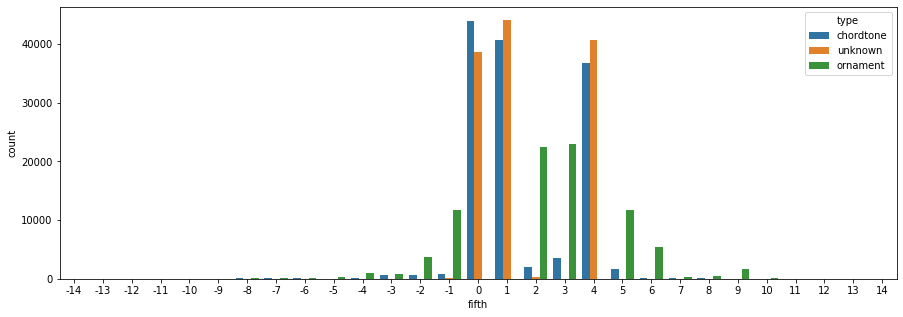

In [11]:
maj_df = wiki_harms[wiki_harms['label']=='major']
plt.figure(figsize=(15,5))
sns.countplot(x='fifth', hue='type', data=maj_df)

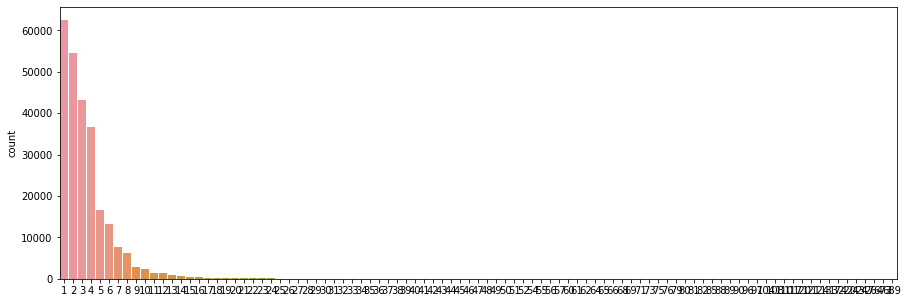

In [12]:
sizes = wiki_harms.groupby(['chordid', 'label']).size()
plt.figure(figsize=(15,5))
sns.countplot(sizes)

In [13]:
type_counts = sizes.groupby('label').size().sort_values(ascending=False)
print(type_counts)
wiki_harmtypes = type_counts.index.tolist()
major = wiki_harmtypes.index('major')
print("major =", major)

label
major                 89097
dominant              60172
minor                 29973
minor-seventh         26429
major-seventh          8337
major-sixth            5553
dominant-ninth         5497
diminished             3790
min                    2814
7                      2778
minor-sixth            2665
half-diminished        2085
suspended-fourth       1969
diminished-seventh     1767
augmented-seventh      1590
augmented              1308
min7                   1057
dominant-13th          1003
maj7                    952
dominant-seventh        881
minor-ninth             849
major-ninth             556
dominant-11th           230
power                   218
suspended-second        191
minor-11th              181
minor-major             155
dim                     152
augmented-ninth          86
9                        80
6                        62
other                    61
major-minor              58
sus47                    51
min9                     46
aug           

In [14]:
wiki_harms['numlabel'] = wiki_harms['label'].map(wiki_harmtypes.index)

<ipython-input-14-b73e47b0e841>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wiki_harms['numlabel'] = wiki_harms['label'].map(wiki_harmtypes.index)


In [15]:
wiki_harms

,chordid,label,fifth,type,numlabel
0,0,dominant-13th,3,chordtone,17
1,1,major-sixth,1,unknown,5
2,1,major-sixth,1,unknown,5
3,1,major-sixth,4,chordtone,5
4,1,major-sixth,3,unknown,5
...,...,...,...,...,...
898967,279831,major,0,chordtone,0
898968,279832,minor,-3,unknown,2
898969,279832,minor,1,unknown,2
898970,279832,minor,1,unknown,2


In [16]:
wiki_chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
              for (_, label), grp in wiki_harms.groupby(['chordid', 'numlabel'])]

In [18]:
wiki_obs = annot_data_obs(wiki_chords)
wiki_obs

{'chord': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'h': tensor([17,  5,  4,  ...,  1,  0,  2]),
 'n': tensor([0., 3., 2.,  ..., 2., 1., 3.])}

In [19]:
wiki_obs['chord'][wiki_obs['h'] == major].reshape(-1, npcs).sum(dim=0)

tensor([1.0000e+00, 1.0000e+00, 1.6000e+01, 2.9000e+01, 2.1000e+01, 6.4000e+01,
        1.9300e+02, 1.4300e+02, 2.4100e+02, 4.2700e+02, 1.0830e+03, 1.4910e+03,
        4.2890e+03, 1.2741e+04, 8.2642e+04, 8.4774e+04, 2.4710e+04, 2.6459e+04,
        7.7528e+04, 1.3503e+04, 5.6260e+03, 4.5900e+02, 7.0100e+02, 1.6720e+03,
        2.0600e+02, 6.9000e+01, 5.0000e+01, 4.4000e+01, 9.0000e+00])

In [20]:
nharms = len(wiki_harmtypes)
nchords = len(wiki_chords)
print(nharms, "chord types")
print(nchords, "chords")

48 chord types
252875 chords


## Inference

100%|██████████| 5000/5000 [04:39<00:00, 17.90it/s]


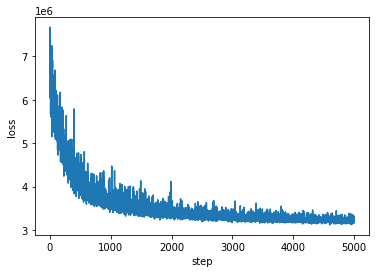

In [21]:
# optimize the parameters of the guide
pyro.clear_param_store()
svi = pyro.infer.SVI(model=chord_model,
                     guide=chord_guide,
                     optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                     loss=pyro.infer.Trace_ELBO())

# set up collection of intermediate values for the loss and some of the parameters
losses = []
param_values = {name:[] for name in ['alpha_rate_notes', 'beta_rate_notes', 'alpha_p_ict', 'beta_p_ict']}

# configuration values
nsteps = 5_000
subsamples = 10_000 # 10_000 is pretty fast (~15 it/s), but lower values are fine wrt. variance

# run the optimization
for i in tqdm.trange(nsteps):
    losses.append(svi.step(npcs, nharms, wiki_obs, subsamples))
    ps = pyro.get_param_store()
    for (name, value) in ps.items():
        if name in param_values:
            param_values[name].append(value.item())

# plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

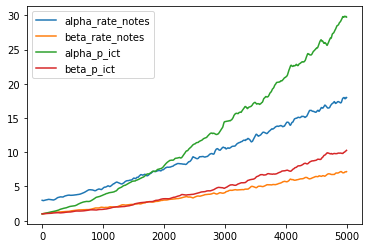

In [22]:
df = pd.DataFrame(param_values)
df.plot()

In [23]:
# show optimized parameters:
for (name, value) in pyro.get_param_store().items():
    print(name, ":\t", value)

params_p_harmony :	 tensor([1.6955e+02, 1.1311e+02, 5.7604e+01, 5.0289e+01, 1.6120e+01, 1.0881e+01,
        1.0257e+01, 7.5781e+00, 5.5496e+00, 5.5092e+00, 5.0219e+00, 4.1154e+00,
        3.8970e+00, 3.4281e+00, 3.2048e+00, 2.6849e+00, 2.3670e+00, 2.0392e+00,
        2.0463e+00, 1.9126e+00, 1.8913e+00, 1.3621e+00, 7.2402e-01, 6.9374e-01,
        6.5669e-01, 6.1270e-01, 5.8086e-01, 5.6451e-01, 3.6071e-01, 3.0195e-01,
        1.7931e-01, 2.1039e-01, 1.4906e-01, 1.2649e-01, 1.1716e-01, 9.0612e-02,
        5.0665e-02, 4.6877e-02, 4.7134e-02, 4.3072e-02, 3.9648e-02, 3.4342e-02,
        3.5143e-02, 2.9854e-02, 2.8742e-02, 2.7015e-02, 3.0104e-02, 2.9757e-02],
       grad_fn=<AddBackward0>)
params_p_chordtones :	 tensor([[0.0226, 0.0223, 0.0242,  ..., 0.0355, 0.0277, 0.0230],
        [0.0297, 0.0310, 0.0333,  ..., 0.2329, 0.1973, 0.0326],
        [0.0310, 0.0320, 0.0322,  ..., 0.0435, 0.0775, 0.0315],
        ...,
        [0.4980, 0.5014, 0.4891,  ..., 0.4812, 0.4827, 0.4998],
        [0.5051,

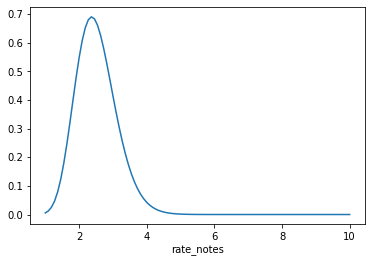

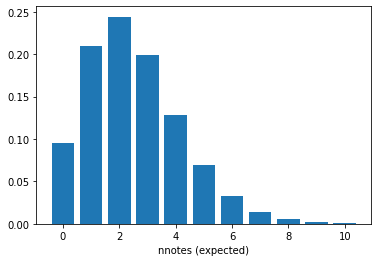

In [24]:
# posterior of 'rate_notes'
a = pyro.get_param_store().get_param("alpha_rate_notes").item()
b = pyro.get_param_store().get_param("beta_rate_notes").item()
x = np.linspace(1,10,100)
y = np.exp(Gamma(a,b).log_prob(x))
plt.plot(x,y)
plt.xlabel('rate_notes')
plt.show()
xrate = torch.linspace(0,10,11)
yrate = np.exp(GammaPoisson(a,b).log_prob(xrate))
plt.bar(xrate, yrate)
plt.xlabel('nnotes (expected)')
plt.show()

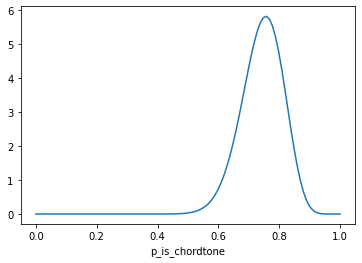

In [25]:
# posterior of 'p_is_chordtone'
post_p_ict_alpha = pyro.get_param_store().get_param("alpha_p_ict").item()
post_p_ict_beta  = pyro.get_param_store().get_param("beta_p_ict").item()
x = torch.linspace(0,1,100)
y = np.exp(Beta(post_p_ict_alpha, post_p_ict_beta).log_prob(x))
plt.plot(x,y)
plt.xlabel("p_is_chordtone")
plt.show()

In [26]:
post_p_harmony = pyro.get_param_store().get_param("params_p_harmony").detach()

In [27]:
def plot_chord_type_dist(params, labels):
    plt.figure(figsize=(6,9))
    plt.barh(np.arange(len(params)), params, tick_label=labels)
    plt.show()

tensor([1.6955e+02, 1.1311e+02, 5.7604e+01, 5.0289e+01, 1.6120e+01, 1.0881e+01,
        1.0257e+01, 7.5781e+00, 5.5496e+00, 5.5092e+00, 5.0219e+00, 4.1154e+00,
        3.8970e+00, 3.4281e+00, 3.2048e+00, 2.6849e+00, 2.3670e+00, 2.0392e+00,
        2.0463e+00, 1.9126e+00, 1.8913e+00, 1.3621e+00, 7.2402e-01, 6.9374e-01,
        6.5669e-01, 6.1270e-01, 5.8086e-01, 5.6451e-01, 3.6071e-01, 3.0195e-01,
        1.7931e-01, 2.1039e-01, 1.4906e-01, 1.2649e-01, 1.1716e-01, 9.0612e-02,
        5.0665e-02, 4.6877e-02, 4.7134e-02, 4.3072e-02, 3.9648e-02, 3.4342e-02,
        3.5143e-02, 2.9854e-02, 2.8742e-02, 2.7015e-02, 3.0104e-02, 2.9757e-02])
['major', 'dominant', 'minor', 'minor-seventh', 'major-seventh', 'major-sixth', 'dominant-ninth', 'diminished', 'min', '7', 'minor-sixth', 'half-diminished', 'suspended-fourth', 'diminished-seventh', 'augmented-seventh', 'augmented', 'min7', 'dominant-13th', 'maj7', 'dominant-seventh', 'minor-ninth', 'major-ninth', 'dominant-11th', 'power', 'suspended-secon

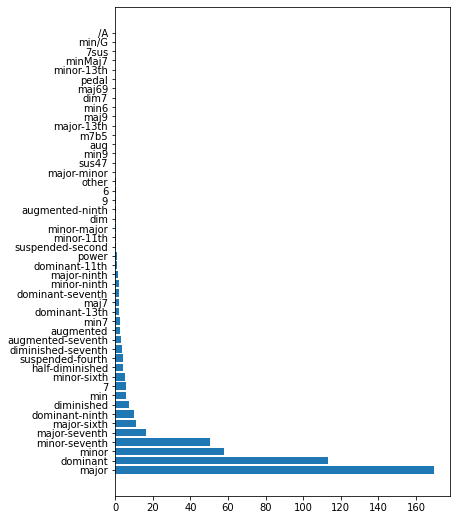

In [28]:
#post_p_harmony = pyro.get_param_store().get_param("params_p_harmony").detach().numpy()
print(post_p_harmony)
print(wiki_harmtypes)

plot_chord_type_dist(post_p_harmony, wiki_harmtypes)

In [29]:
def plot_chord(chordtones, ornaments, name):
    #cs = np.roll(chordtones, fifth_range)
    #os = np.roll(ornaments, fifth_range)
    labels = np.arange(-fifth_range, fifth_range+1)
    x = np.arange(npcs)
    width = 0.4
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar(x - width/2, chordtones, width, label='chord tones')
    plt.bar(x + width/2, ornaments, width, label='ornaments')
    ax.set_title(name)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
#     fig, ax = plt.subplots(2, 1, figsize=(12,9))
#     ax[0].bar(np.arange(npcs), cs, tick_label=labels)
#     ax[0].set_title("{} chord tones".format(name))
#     ax[1].bar(np.arange(npcs), os, tick_label=labels)
#     ax[1].set_title("{} ornaments".format(name))
    plt.show()

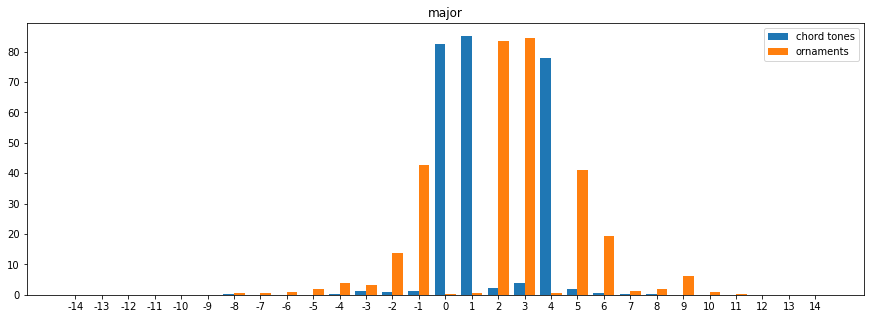

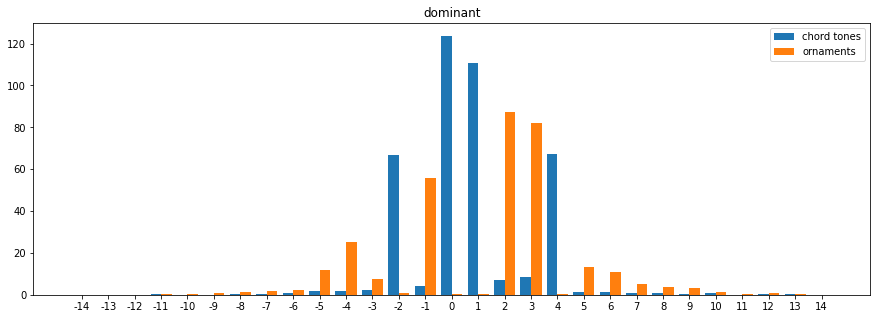

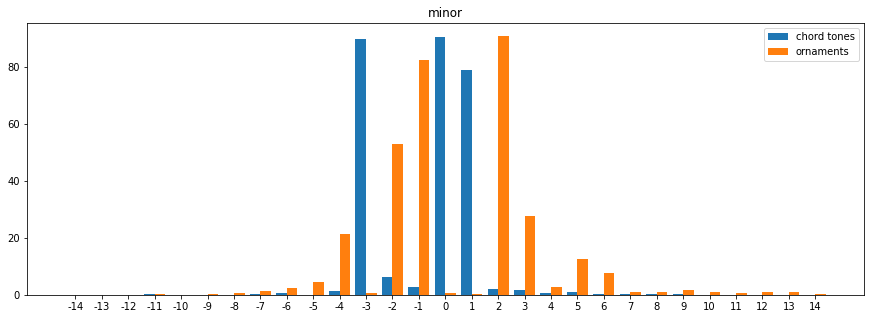

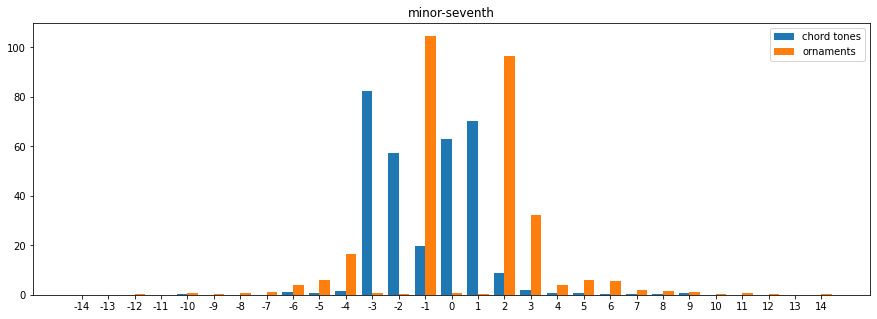

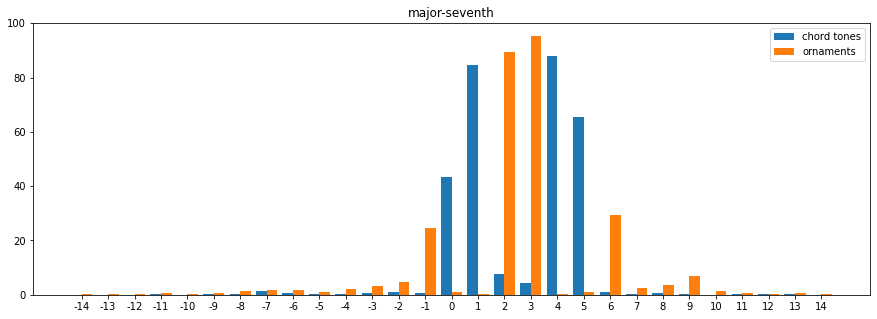

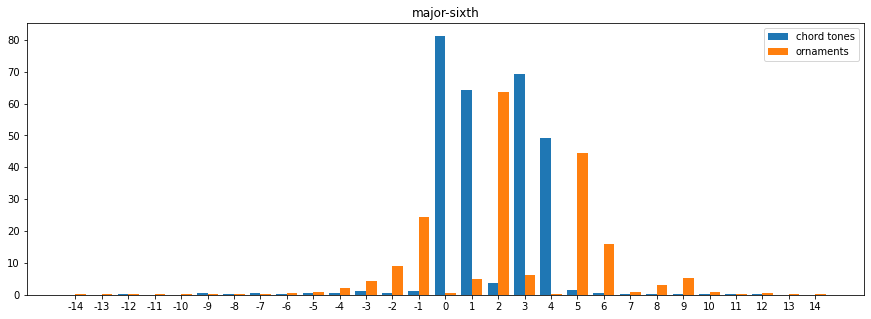

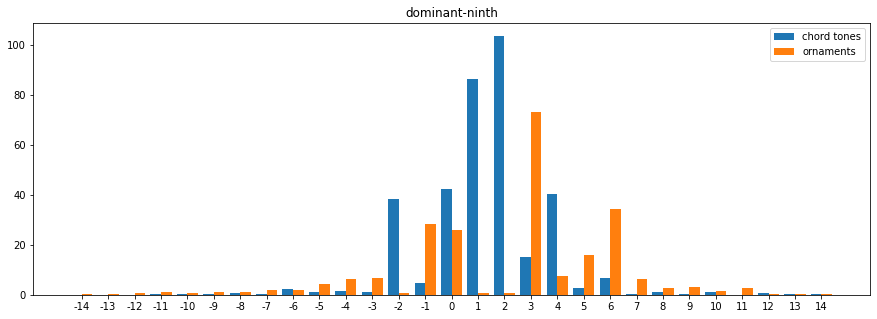

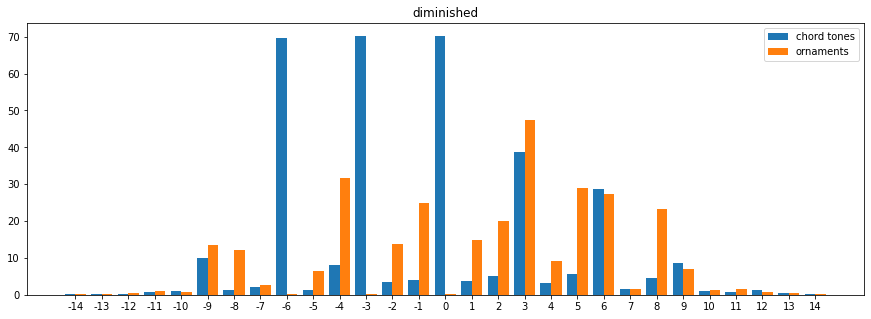

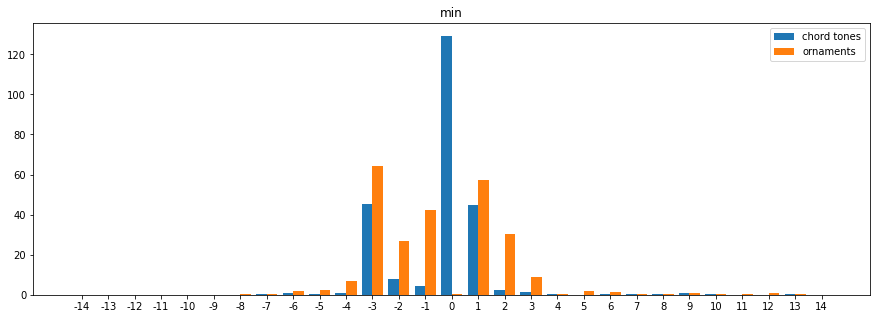

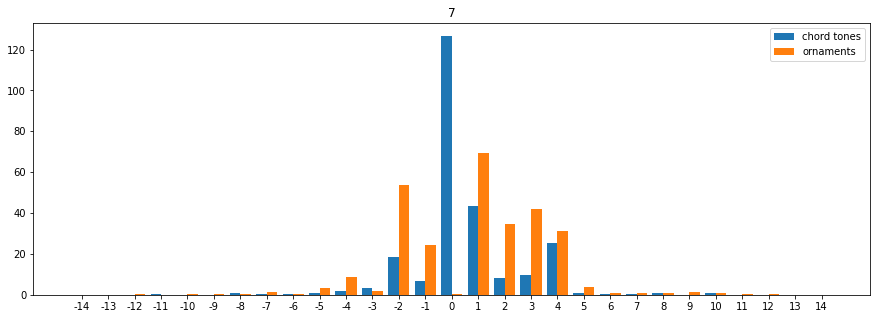

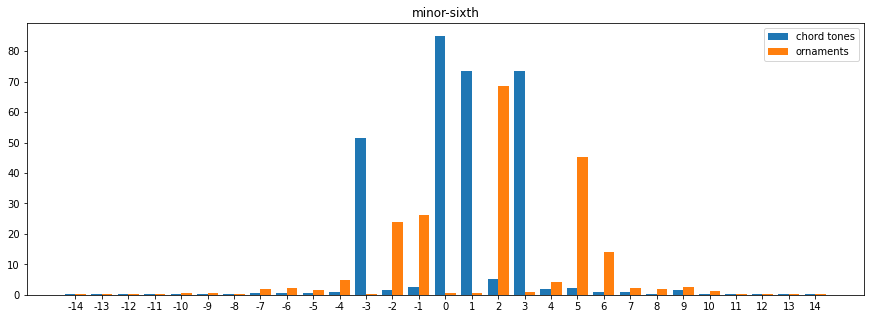

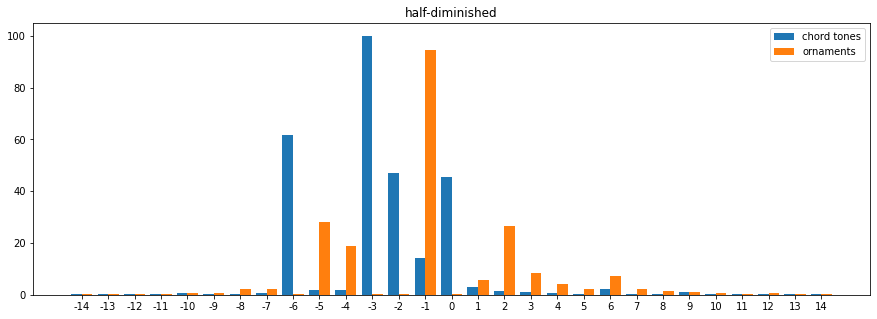

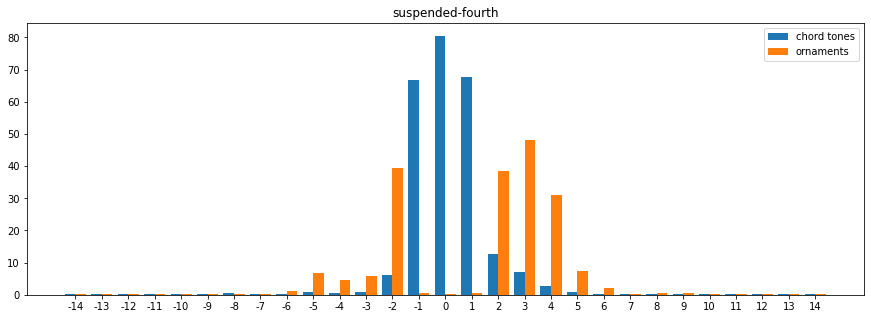

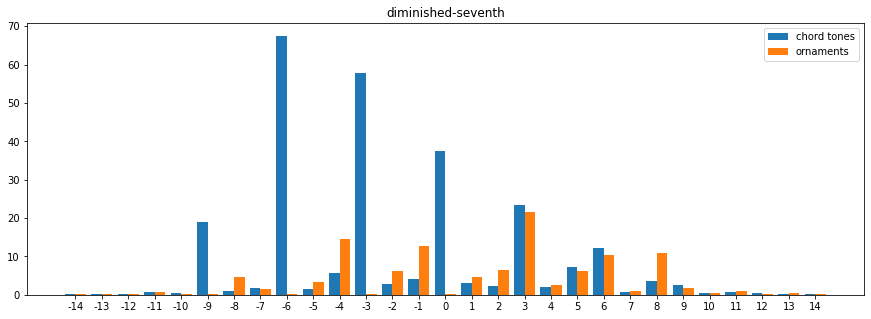

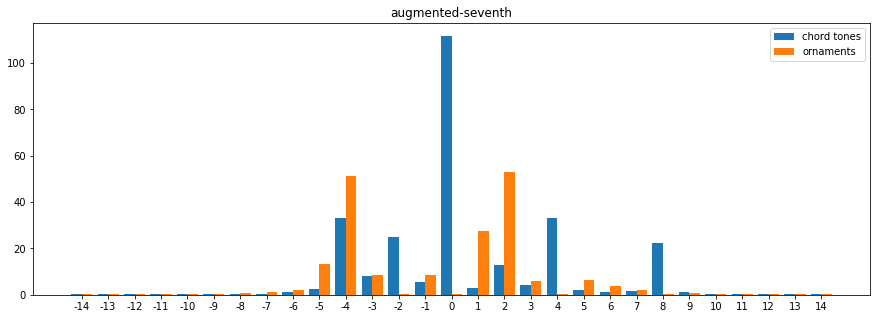

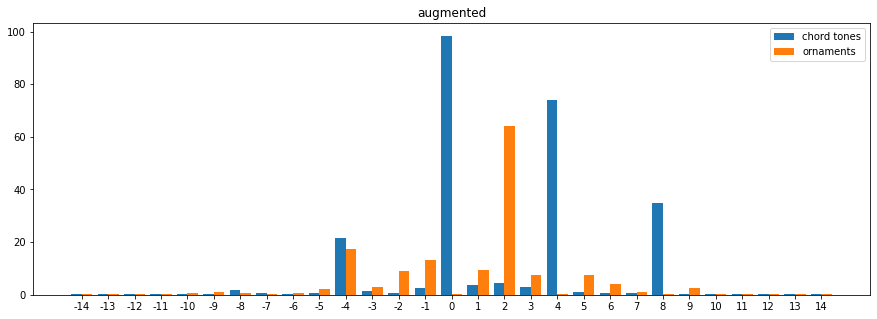

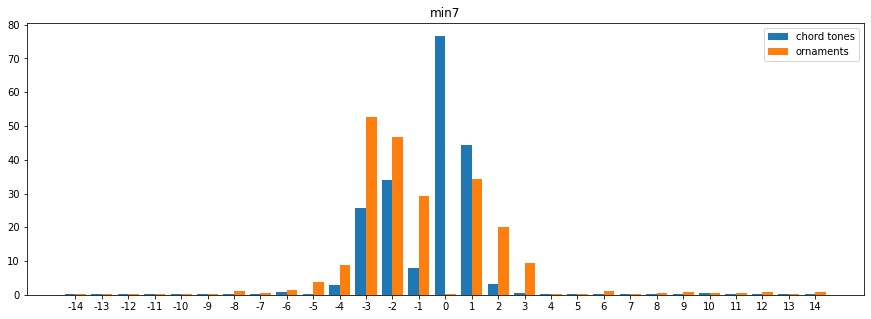

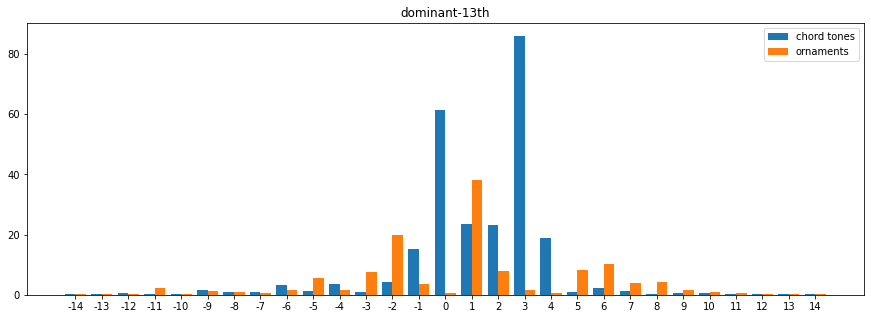

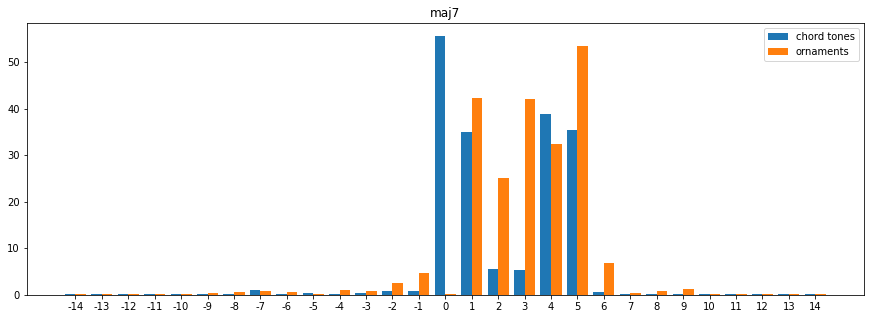

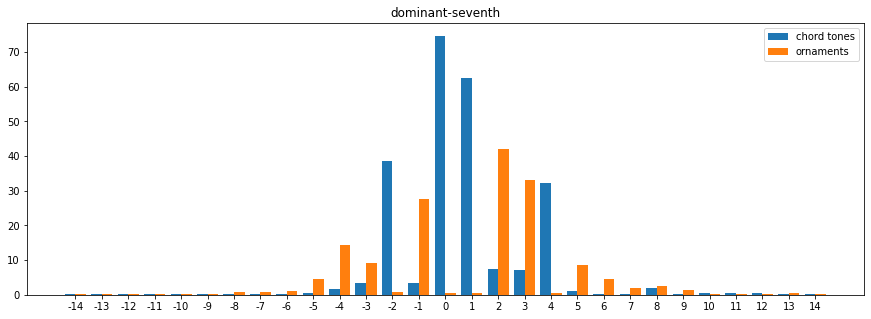

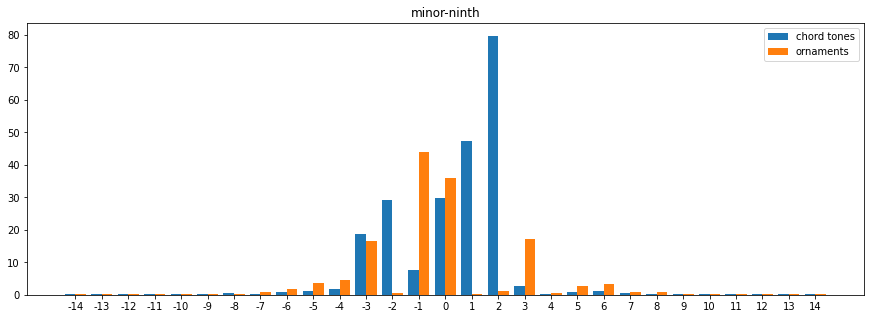

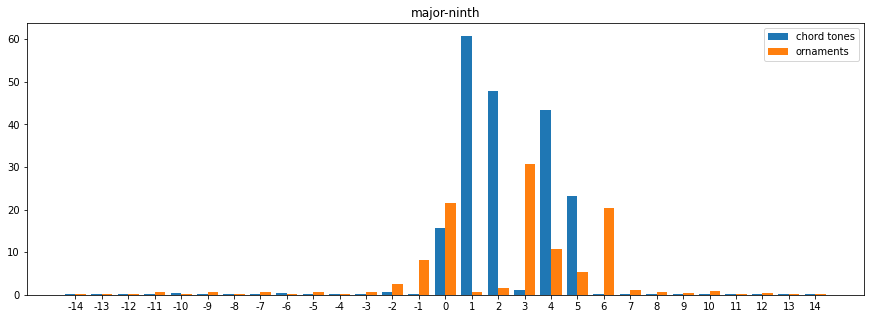

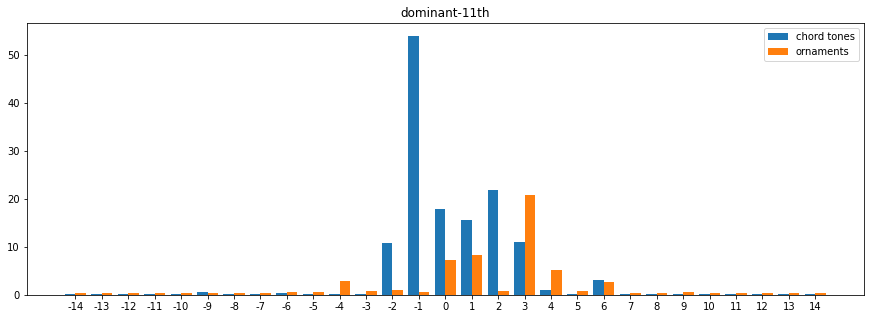

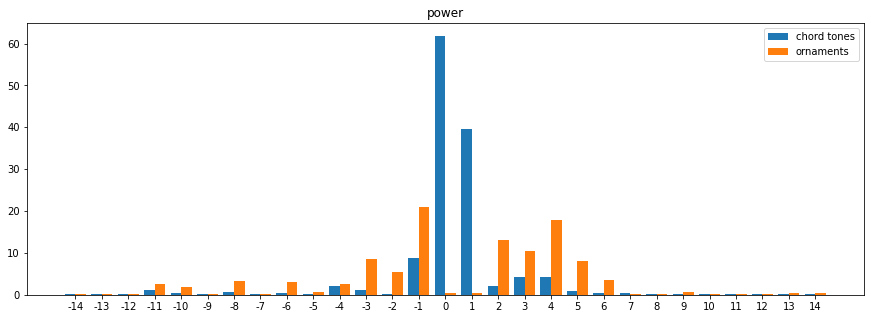

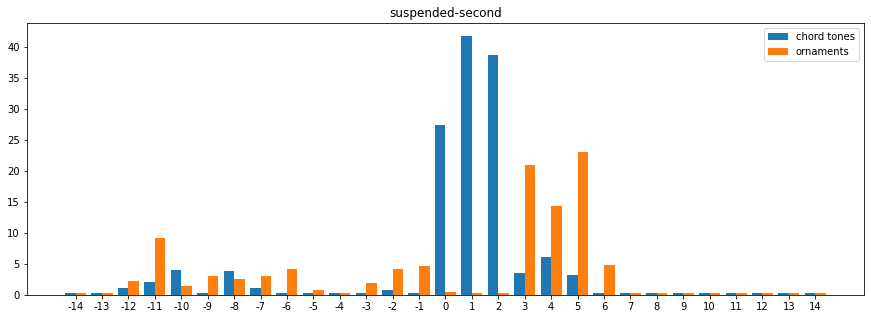

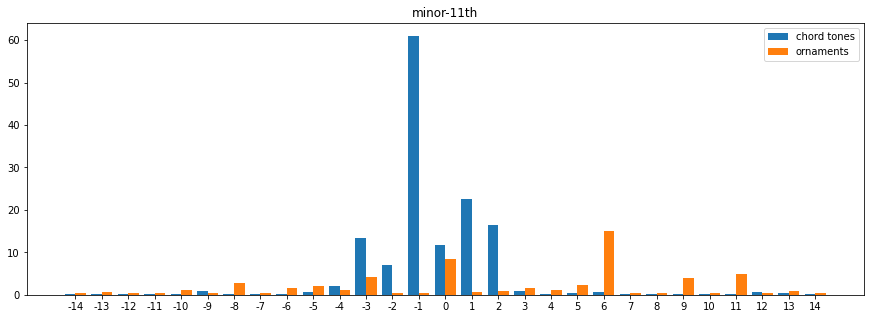

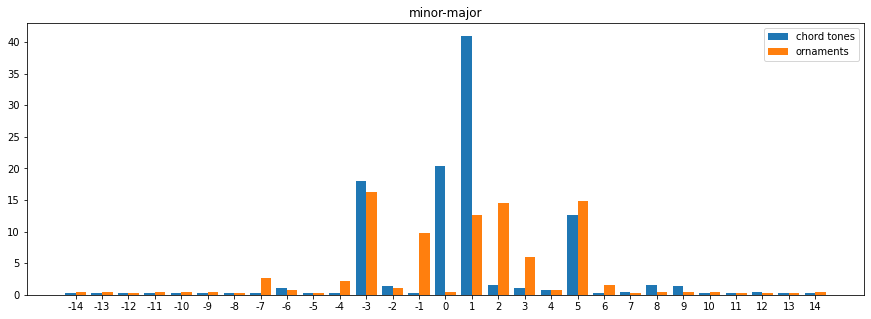

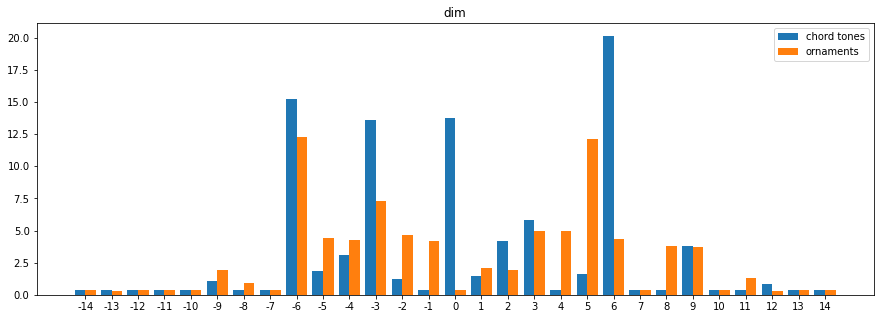

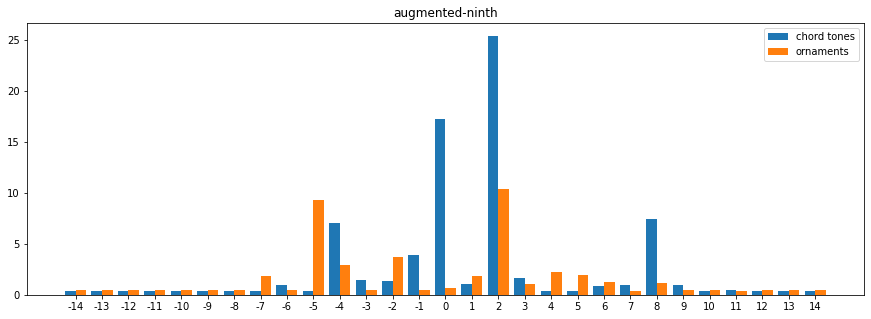

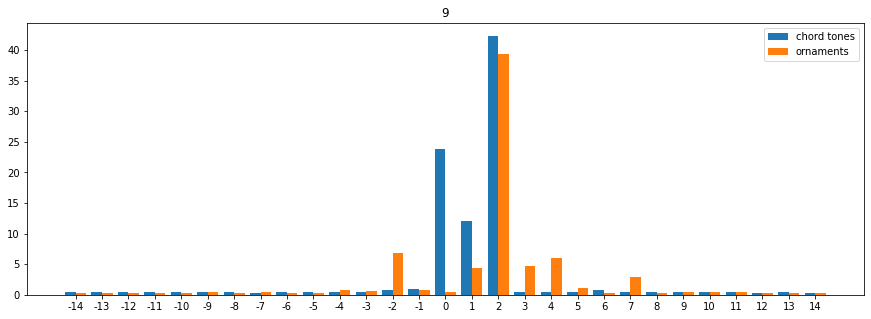

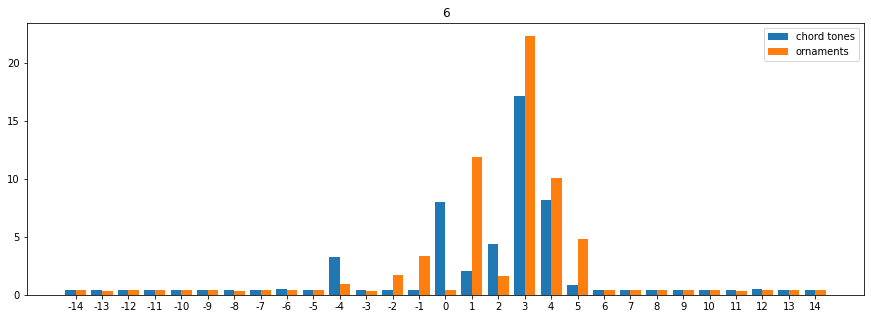

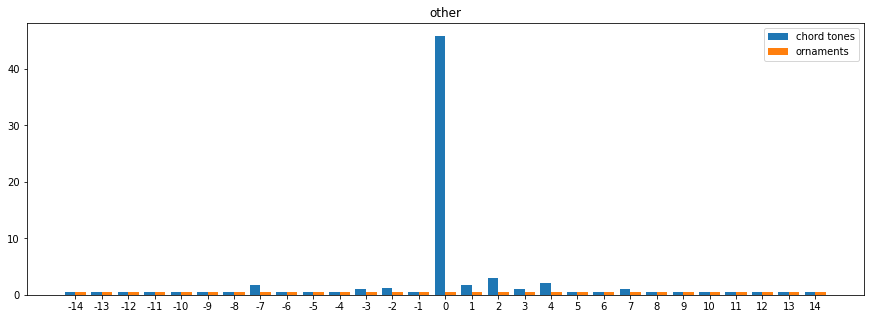

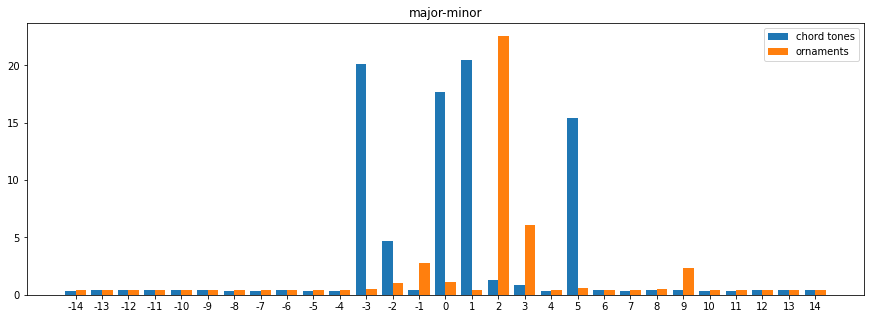

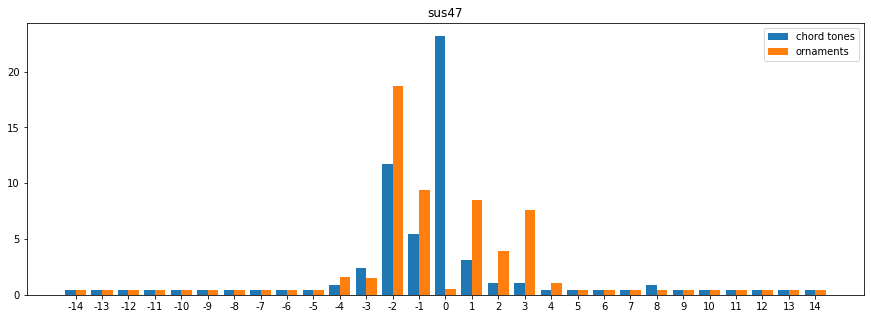

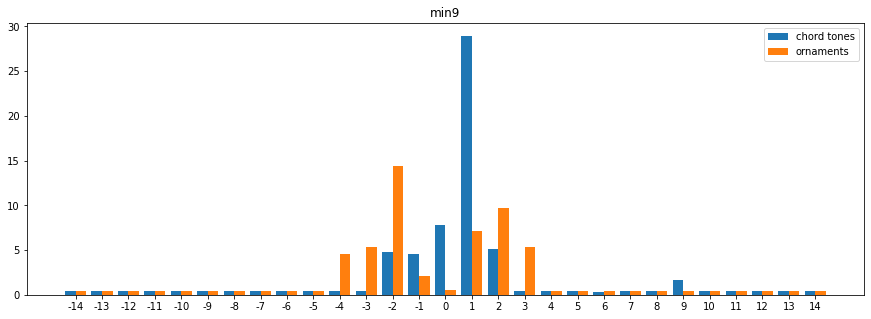

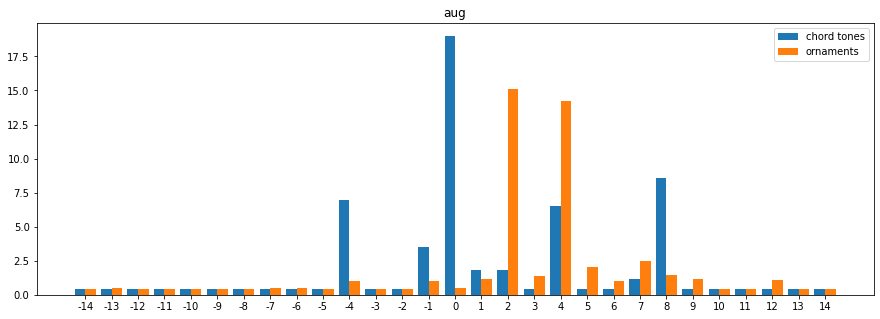

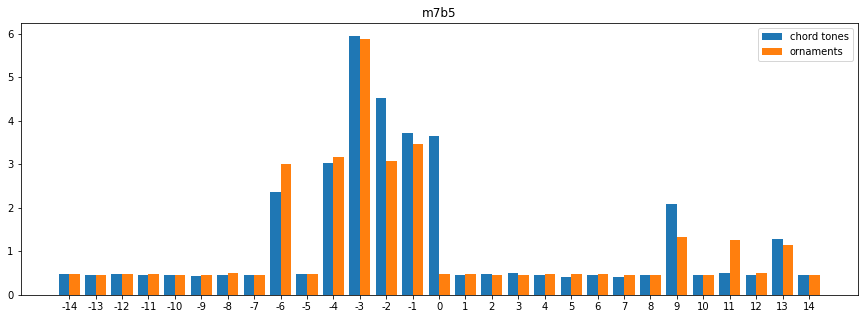

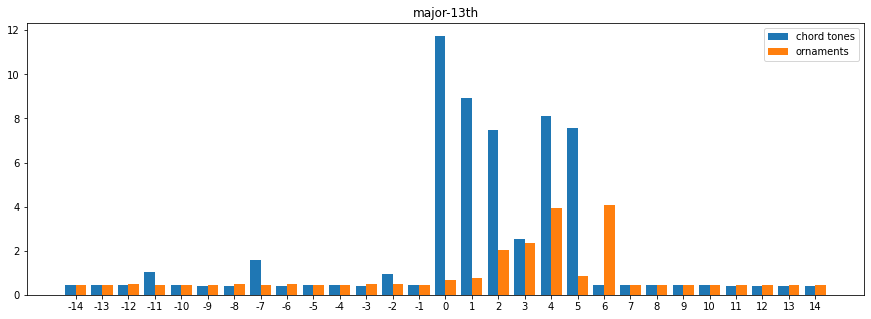

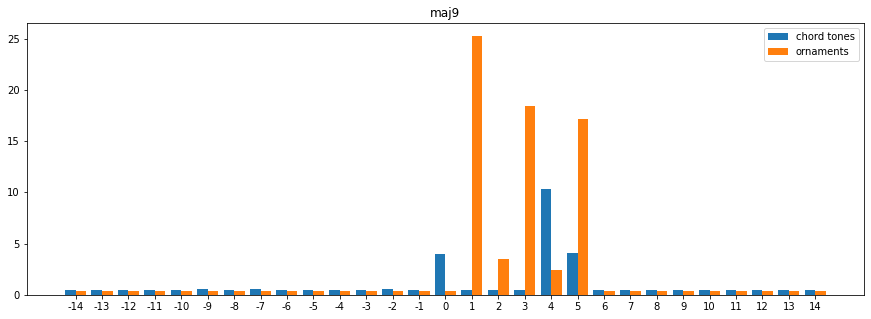

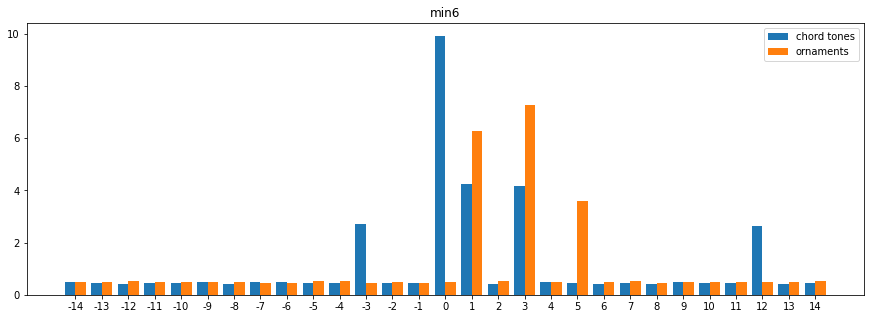

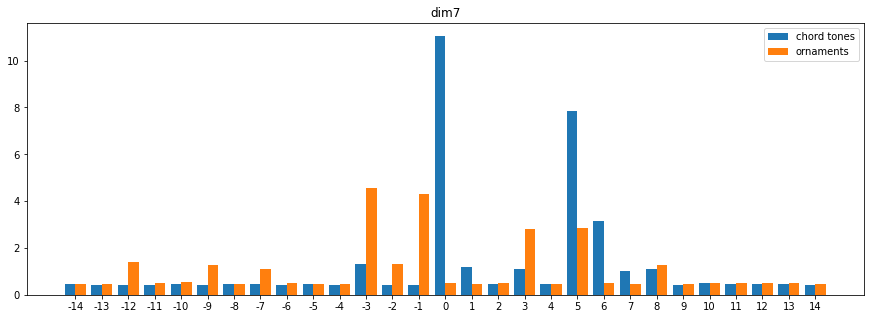

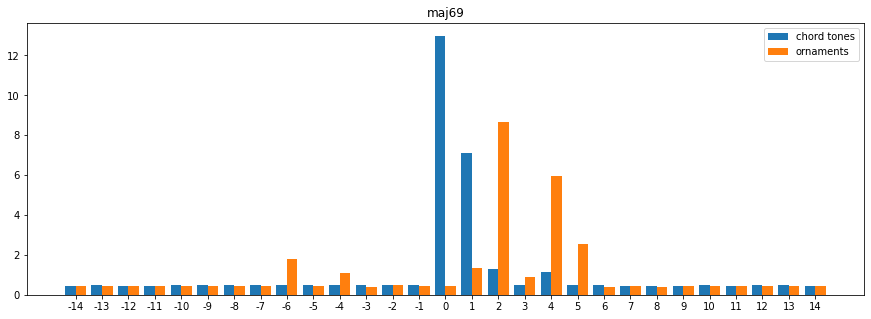

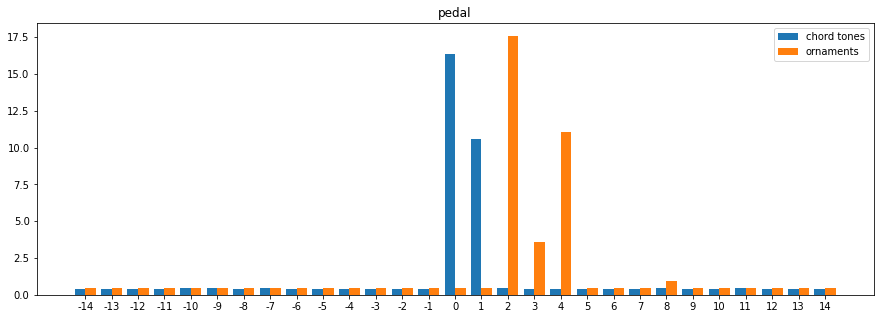

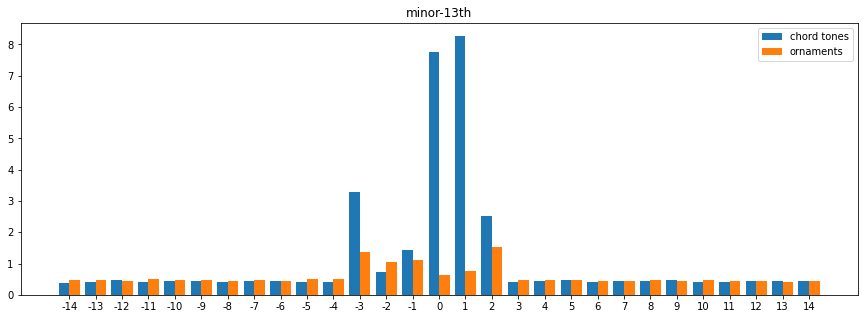

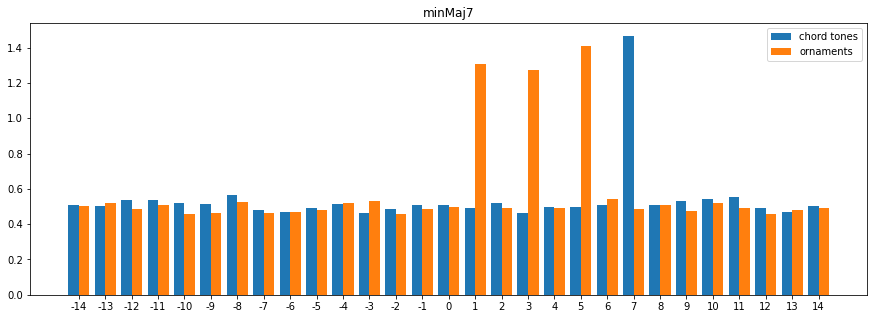

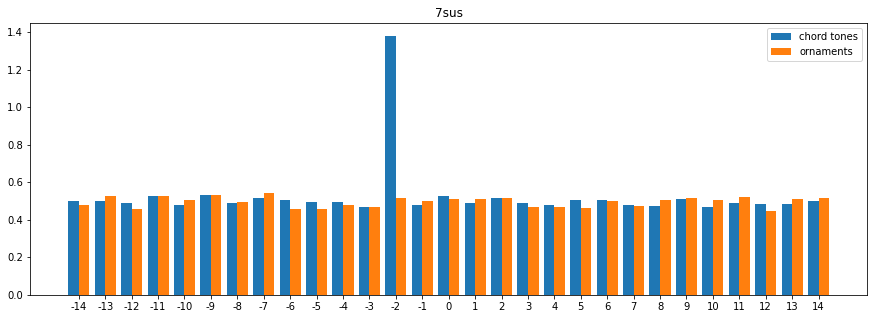

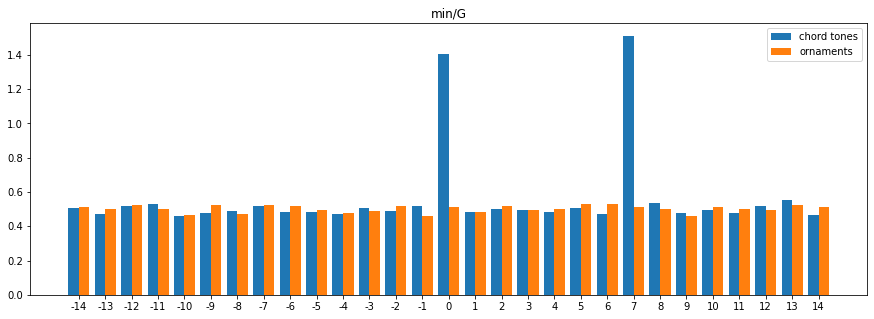

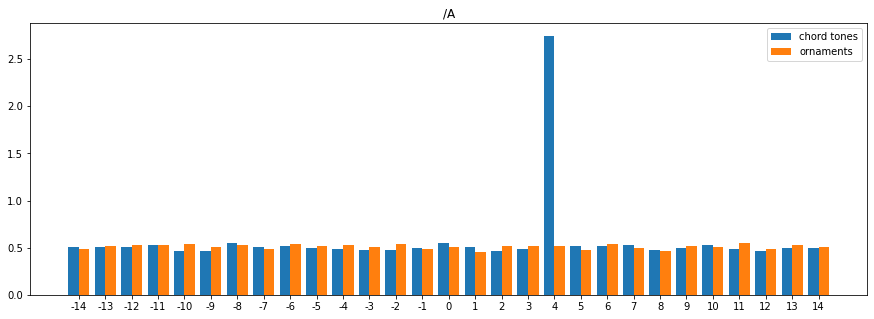

In [30]:
post_chordtones = pyro.get_param_store().get_param("params_p_chordtones").detach()
post_ornaments = pyro.get_param_store().get_param("params_p_ornaments").detach()
for i, name in enumerate(wiki_harmtypes):
    plot_chord(post_chordtones[i], post_ornaments[i], name)

# Prediction

once the posterior distribution of the chord types are known, we can use them to predict the chord type of a (new) set of notes.

$$
p(h \mid n', D) = \dfrac{p(n' \mid h, D) p(h \mid D)}{p(n' \mid D)}
$$

$p(h \mid D)$ is represented in the (approximate) posterior by the Dirichlet distribution $p(\chi \mid D)$.
It can be expressed as
$$p(h \mid D) = \int p(h \mid \chi) p(\chi \mid D) d\chi,$$
where $\chi$ is the parameter vector for the categorical Distribution of $h$.

$p(n' \mid h, D)$ is represented in the posterior as a combination of the dirichlet distributions of chord tones $p(\phi_{ct}^{(h)} \mid D)$ and ornaments $p(\phi_{or}^{(h)} \mid D)$ and the beta distribution of the chord-tone probability $p(\theta \mid D)$.
$$
  p(n' \mid h, D) = \int \int \int p(n' \mid \phi_{ct}^{(h)}, \phi_{or}^{(h)}, \theta)
    p(\phi_{ct}^{(h)} \mid D) p(\phi_{or}^{(h)} \mid D) p(\theta \mid D)\ d \phi_{ct}^{(h)} d \phi_{or}^{(h)} d \theta,
$$
where
$$
  p(n' \mid  \phi_{ct}^{(h)}, \phi_{or}^{(h)}, \theta) = Multinomial(|n'|, \nu),
$$
with $\nu$ as defined above.

Since this integral is a bit tricky to calculate (\*ahem\*) we write another model and guide to numerically compute the distribution $p(h \mid n', D)$

In [31]:
def chord_model_pred(npcs, nharmonies, obs_chords, pobserve=0.5):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', Dirichlet(post_p_harmony))
    # distribution of ornament probability
    p_is_chordtone = pyro.sample('p_is_chordtone', Beta(post_p_ict_alpha, post_p_ict_beta))
    # distribution of notes in the harmonies
    with pyro.plate('harmonies', nharmonies) as ind:
        # distribution of notes per note type
        p_chordtones = pyro.sample('p_chordtones', Dirichlet(post_chordtones))
        p_ornaments  = pyro.sample('p_ornaments', Dirichlet(post_ornaments))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        p_ct = p_is_chordtone       * p_chordtones
        p_or = (1 - p_is_chordtone) * p_ornaments
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    
    # sample the chord
    nchords = obs_chords.shape[0]
    with pyro.plate('chords', nchords):
        h = pyro.sample('h', Categorical(p_harmony))
        chord = pyro.sample('chord', Multinomial(1, p_tones[h], validate_args=False), obs=obs_chords)
    return h, chord

In [32]:
chord_model_pred(npcs, nharms, chord_tensor(wiki_chords[0]['notes']).reshape(1,-1))

(tensor([1]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [33]:
@pyro.infer.config_enumerate
def chord_guide_pred(npcs, nharmonies, obs_chords, pobserve=0.5):
    # sample according to known posterior
    pyro.sample('p_harmony', Dirichlet(post_p_harmony))
    pyro.sample('p_is_chordtone', Beta(post_p_ict_alpha, post_p_ict_beta))
    with pyro.plate('harmonies', nharmonies) as ind:
        pyro.sample('p_chordtones', Dirichlet(post_chordtones))
        pyro.sample('p_ornaments', Dirichlet(post_ornaments))
    
    # estimate the predictive
    nchords = obs_chords.shape[0]
    p_harmony = pyro.param('params_h', torch.ones(nchords,nharmonies) / nharmonies, constraint=constraints.simplex)
    #nnotes = obs_chord.sum().int()
    with pyro.plate("chords", nchords):
        h = pyro.sample('h', Categorical(p_harmony))

In [34]:
def predict(npcs, nharmonies, chords, pobserve=0.5, iterations=100, plot_loss=True):
    obs_chord = torch.cat([chord_tensor(notes).reshape(1,-1) for notes in chords], dim=0)
    pyro.clear_param_store()
    svi = pyro.infer.SVI(model=chord_model_pred,
                         guide=chord_guide_pred,
                         optim=pyro.optim.Adam({"lr": 0.005, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.TraceEnum_ELBO(max_plate_nesting=1))

    losses = []

    for i in tqdm.trange(iterations):
        losses.append(svi.step(npcs, nharms, obs_chord, pobserve))
        
    if plot_loss:
        plt.plot(losses)
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.show()
    
    return pyro.get_param_store().get_param('params_h').detach()

We can run predictive inference on some of our data.
Note that this is not a proper evaluation since we use the same data for training and prediction.
Furthermore, we can't expect our predictions to be very good, since the data only contains the melodic part, which makes it very difficult to infer the correct harmony.

100%|██████████| 1500/1500 [01:56<00:00, 12.90it/s]


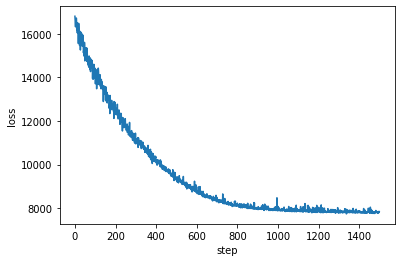

In [35]:
pred = predict(npcs, nharms, [c['notes'] for c in wiki_chords[0:1000]], iterations=1500)

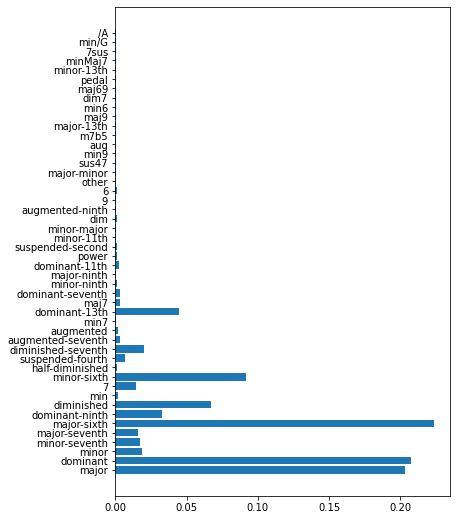

In [36]:
plot_chord_type_dist(pred[0], wiki_harmtypes)

In [37]:
wiki_chords[0]['notes']

[(3, 'chordtone')]

In [38]:
wiki_harmtypes[wiki_chords[0]['label']]

'dominant-13th'

In [39]:
wiki_harmtypes[pred[0].argmax().item()]

'major-sixth'

In [40]:
labels = np.array([wiki_harmtypes[c['label']] for c in wiki_chords[0:1000]])
predictions = np.array([wiki_harmtypes[p] for p in pred.argmax(dim=1)])
sum(l != p for (l,p) in zip(labels, predictions))

438

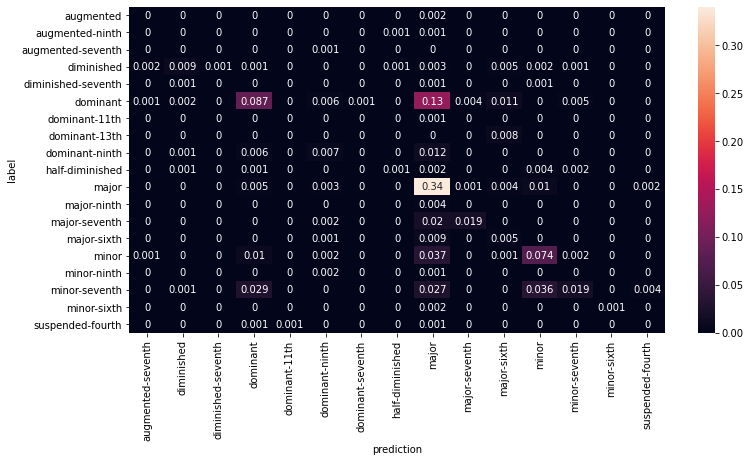

In [41]:
conf = pd.crosstab(labels, predictions, rownames=['label'], colnames=['prediction'], normalize=True)
plt.figure(figsize=(12,6))
sns.heatmap(conf, annot=True)